To start with, let's download some scripts from a GitHub repository that implement a DBN in PyTorch.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from DBN import DBN

# Obtain Data 

The dataset used in this case is from EMNIST. The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 (https://www.nist.gov/srd/nist-special-database-19) and converted to a ***28x28*** pixel image format and dataset structure that directly matches the MNIST dataset (http://yann.lecun.com/exdb/mnist/). Here I used EMNIST Digits dataset that contains ***240,000 characters*** and ***10 balanced classes.***   


In [ ]:
emnist_data = tv.datasets.EMNIST('data/', train=True, download=True,
                split='digits',
                transform=tv.transforms.Compose(
                [tv.transforms.ToTensor(), tv.transforms.Normalize((0.13070,), (0.3081,))]))

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
emnist_data.classes
len(emnist_data)

240000

The number shown is the number: 0


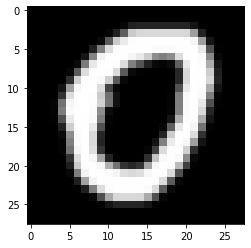

In [ ]:
emnist_data.data = (emnist_data.data.type(torch.FloatTensor)/255)

idx = 101
img = emnist_data.data[idx]
print("The number shown is the number: {}".format(emnist_data.targets[idx]))
plt.imshow(img , cmap = 'gray')
plt.show()

Splitting the dataset in to training set and testing set.

In [ ]:
emnist_data_train = emnist_data.data[10000:, :]
emnist_targets_train = emnist_data.targets[10000:]

emnist_data_test = emnist_data.data[:10000, :]
emnist_targets_test = emnist_data.targets[:10000]

# Training DBN

Becasue the images are ***28×28*** pixel, so the parameter of visible_units is ***28×28***. In this DBN, I created ***3 RBM hidden layers***, which has ***500*** units, ***500*** units and ***1000*** units respectively. As shown in the figure, the input layer has ***784*** hidden neurons, the h1 and h2 both have 500 neurons, and the h3 has 1000 neurons. The presentation learning between different hidden layers is unsupervised, while the digit detectior is supervised. At the end of the unsupervised learning phase, we can add one output layer encoding categories (labels). The output layer is fully connected to the deepest hidden layer h3, thereby forming a linear pattern associator that can be trained with supervised learning.

Exploiting more layers can extract more information and capture more features, so the DBN can represent the data and learn a hierarchical generative model better. However, The deeper the network, the more computation and the longer the running time. Considering the computing ability and running time, I just tried 500×500 DBN and 500×500×1000 DBN, and the 500×500×1000 architecture had better performance than 2 layers architecture.

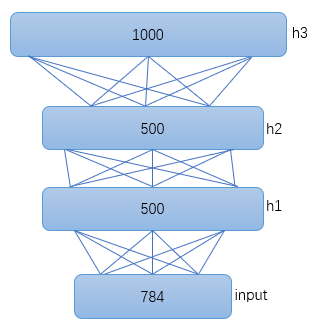

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
          hidden_units=[500, 500, 1000],
          k=1,
          learning_rate=0.1,
          learning_rate_decay=False,
          initial_momentum=0.5,
          final_momentum=0.9,
          weight_decay=0.00002,
          xavier_init=False,
          increase_to_cd_k=False,
          use_gpu=True)

In [ ]:
dbn_emnist.rbm_layers[-1].W

tensor([[ 0.0052, -0.0829,  0.0969,  ..., -0.0205,  0.0524,  0.0521],
        [-0.2158,  0.0443, -0.0326,  ..., -0.0533,  0.0494,  0.0149],
        [ 0.0129, -0.1970,  0.1083,  ..., -0.0157, -0.0253,  0.1445],
        ...,
        [ 0.0535,  0.0660, -0.0305,  ...,  0.0733,  0.1702,  0.0382],
        [ 0.1104, -0.0416,  0.0293,  ..., -0.1358,  0.0797, -0.1368],
        [-0.0879,  0.0781,  0.0435,  ...,  0.0368,  0.0276,  0.0646]],
       device='cuda:0')

In [ ]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8792   |0.0289   |274.8859 |5.4164   |
|20    |0.8480   |0.0274   |261.0298 |4.8072   |
|30    |0.8422   |0.0279   |258.4835 |4.9491   |
|40    |0.8383   |0.0268   |255.9082 |4.7456   |
|50    |0.8372   |0.0277   |255.3587 |5.0402   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9185   |0.0289   |193.3529 |3.2487   |
|20    |0.8907   |0.0278   |189.6360 |2.9871   |
|30    |0.8835   |0.0270   |188.8735 |2.8485   |
|40    |0.8798   |0.0271   |188.1142 |2.8536   |
|50    |0.8785   |0.0273   |187.6265 |2.9649   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8038   |0.0269   |202.7352 |3.5571   |
|20    |0.7572   |0.0251   |191.8488 |3.0824   |
|30    |0.7470   |0.0252   |190.5357 |3.1489   |
|40    |0.7428   |0.0255   |190.2963 |3.1814   |
|50    |0.7424

***Contrastive Divergence*** was used when training RBM, the model took a layer-by-layer, unsupervised approach to learning parameters. First, take the data vector X and the first hidden layer as an RBM, train the parameters of this RBM (the weight connecting X and h1, the bias of each node of X and h1, etc.). Then fix the parameters of this RBM, take h1 as the visible vector and h2 as the hidden vector, train the second RBM, and get its parameters. Finally fix these parameters and train the RBM composed of h2 and h3.



As we can see from the RBM training result, avg_rec_err and std_rec_err decrease with the number of layers increases, which means deeper layers are beneficial to reduce error in the network. However, the mean_grad and std_grad were not the smallest in the third RBM layer, it reduced from layer1 to layer2, and then increased in the layer3. 

# Visualizing receptive fields

In [ ]:
def _move_parameters_to_cpu(dbn_emnist):
  for layer in dbn_emnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

In [ ]:
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

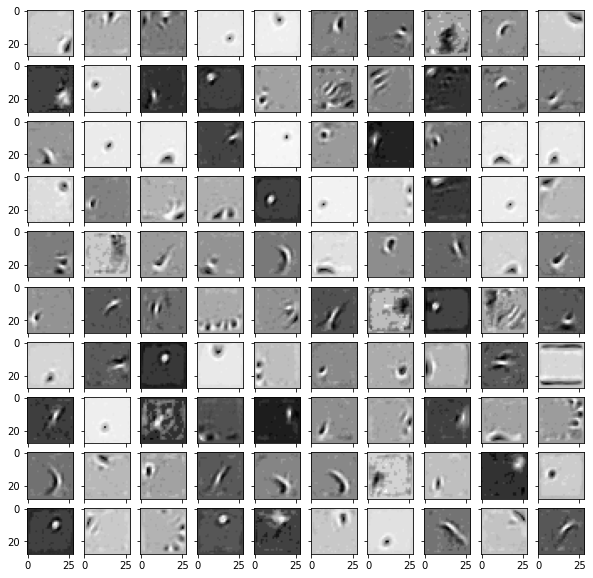

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
_plot_layer_receptive_fields(learned_weights_layer_1)

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_emnist.rbm_layers[2].W.numpy()
print(learned_weights_layer_1.shape)
print(learned_weights_layer_2.shape)
learned_weights_layer_3.shape

(784, 500)
(500, 500)


(500, 1000)

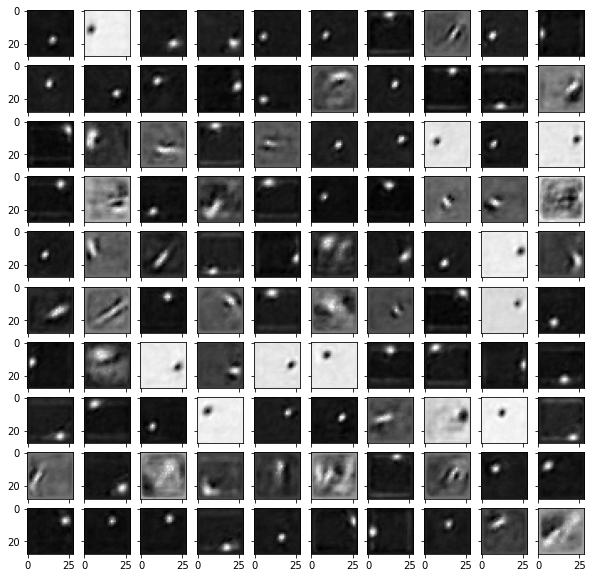

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)

_plot_layer_receptive_fields(learned_weights_product)

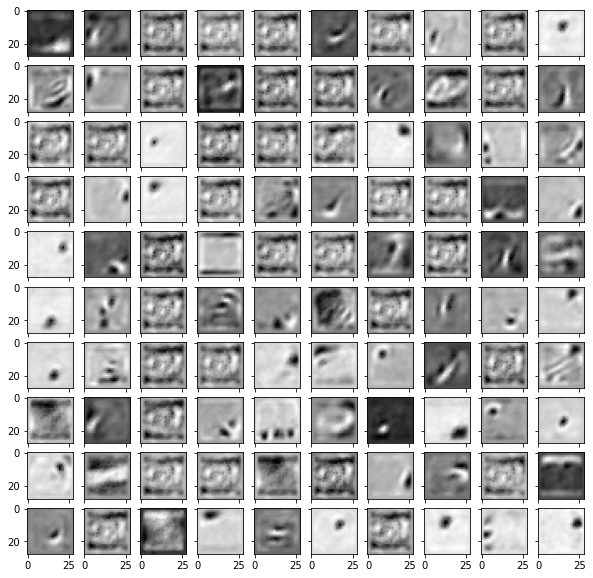

In [ ]:
learned_weights_product1 = (learned_weights_layer_1 @ learned_weights_layer_2 @ learned_weights_layer_3).T
learned_weights_product1 = _apply_threshold(learned_weights_product1, 0)

_plot_layer_receptive_fields(learned_weights_product1)

In the figures, gray means that the weight is close to 0, black means that the weight is negative, and white means positive. Each hidden layer learned different representation from the previous hidden layer, and the deepest layer, h3, can be used to learn digit recognition with supervised learning and fully connected to one more outpuut layer. Finally the emergence of hierarchical representations can make up the final number identification.

# Clustering internal representations

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

Clustering is a method of unsupervised Learning, it refers to the grouping of similar data, regardless of the labels, with the objective of aggregating similar data. 

This implementation of the DBN contains internally several RBM objects. Therefore, we will need to compute the hidden representation using the weights of each RBM contained in the DBN.

In [ ]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)

print(hidden_repr_layer_1.shape)
print(hidden_repr_layer_2.shape)
print(hidden_repr_layer_3.shape)

torch.Size([230000, 500])
torch.Size([230000, 500])
torch.Size([230000, 1000])


Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [ ]:
def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)

In [ ]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [ ]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

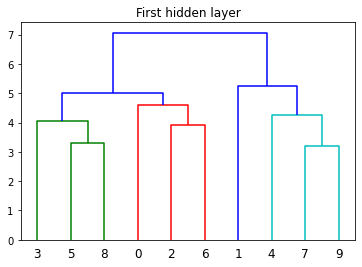

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

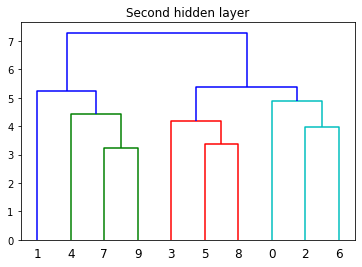

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

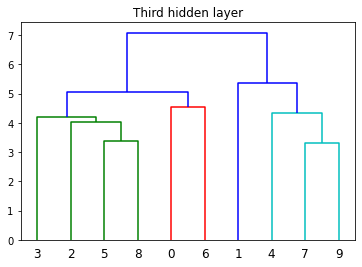

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

The hierarchy of clustering is represented by a tree (or tree graph). The root of the tree is the only cluster that collects all the samples, while the leaf is the cluster with only one sample.

As shown in the figures, in all hidden layers, 5 and 8, 2 and 6, 7 and 9 are clustered to the same group because of the same/similar features, and then clustered this three group together.

# Linear read-out

## h3 hidden layer training

In [ ]:
dbn_emnist.rbm_layers[-1].W.shape

torch.Size([500, 1000])

In [ ]:
# last_layer_size = dbn_emnist.rbm_layers[-1].W.shape[0]
last_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]

class Perceptron3(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
perceptron3 = Perceptron3()

In [ ]:
optimizer = torch.optim.SGD(perceptron3.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 1000

for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron3(hidden_repr_layer_3).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, loss = 2.317681
epoch : 2/1000, loss = 2.266360
epoch : 3/1000, loss = 2.216609
epoch : 4/1000, loss = 2.168374
epoch : 5/1000, loss = 2.121601
epoch : 6/1000, loss = 2.076247
epoch : 7/1000, loss = 2.032267
epoch : 8/1000, loss = 1.989624
epoch : 9/1000, loss = 1.948279
epoch : 10/1000, loss = 1.908197
epoch : 11/1000, loss = 1.869344
epoch : 12/1000, loss = 1.831686
epoch : 13/1000, loss = 1.795190
epoch : 14/1000, loss = 1.759826
epoch : 15/1000, loss = 1.725561
epoch : 16/1000, loss = 1.692364
epoch : 17/1000, loss = 1.660205
epoch : 18/1000, loss = 1.629053
epoch : 19/1000, loss = 1.598880
epoch : 20/1000, loss = 1.569653
epoch : 21/1000, loss = 1.541345
epoch : 22/1000, loss = 1.513927
epoch : 23/1000, loss = 1.487371
epoch : 24/1000, loss = 1.461648
epoch : 25/1000, loss = 1.436731
epoch : 26/1000, loss = 1.412593
epoch : 27/1000, loss = 1.389209
epoch : 28/1000, loss = 1.366552
epoch : 29/1000, loss = 1.344599
epoch : 30/1000, loss = 1.323323
epoch : 31/1000, lo

## h2 hidden layer training

In [ ]:
layer_size = dbn_emnist.rbm_layers[-1].W.shape[0]

class Perceptron2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

perceptron2 = Perceptron2()

optimizer = torch.optim.SGD(perceptron2.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 1000

for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron2(hidden_repr_layer_2).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, loss = 2.363044
epoch : 2/1000, loss = 2.303890
epoch : 3/1000, loss = 2.247792
epoch : 4/1000, loss = 2.194363
epoch : 5/1000, loss = 2.143303
epoch : 6/1000, loss = 2.094376
epoch : 7/1000, loss = 2.047392
epoch : 8/1000, loss = 2.002203
epoch : 9/1000, loss = 1.958688
epoch : 10/1000, loss = 1.916746
epoch : 11/1000, loss = 1.876296
epoch : 12/1000, loss = 1.837265
epoch : 13/1000, loss = 1.799593
epoch : 14/1000, loss = 1.763224
epoch : 15/1000, loss = 1.728106
epoch : 16/1000, loss = 1.694193
epoch : 17/1000, loss = 1.661441
epoch : 18/1000, loss = 1.629809
epoch : 19/1000, loss = 1.599255
epoch : 20/1000, loss = 1.569741
epoch : 21/1000, loss = 1.541230
epoch : 22/1000, loss = 1.513686
epoch : 23/1000, loss = 1.487072
epoch : 24/1000, loss = 1.461356
epoch : 25/1000, loss = 1.436503
epoch : 26/1000, loss = 1.412482
epoch : 27/1000, loss = 1.389261
epoch : 28/1000, loss = 1.366811
epoch : 29/1000, loss = 1.345102
epoch : 30/1000, loss = 1.324105
epoch : 31/1000, lo

## h1 hidden layer training

In [ ]:
layer_size = dbn_emnist.rbm_layers[-1].W.shape[0]

class Perceptron1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

perceptron1 = Perceptron1()

optimizer = torch.optim.SGD(perceptron1.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 1000

for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron1(hidden_repr_layer_1).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, loss = 2.357152
epoch : 2/1000, loss = 2.303908
epoch : 3/1000, loss = 2.253028
epoch : 4/1000, loss = 2.204190
epoch : 5/1000, loss = 2.157168
epoch : 6/1000, loss = 2.111802
epoch : 7/1000, loss = 2.067972
epoch : 8/1000, loss = 2.025587
epoch : 9/1000, loss = 1.984573
epoch : 10/1000, loss = 1.944870
epoch : 11/1000, loss = 1.906426
epoch : 12/1000, loss = 1.869194
epoch : 13/1000, loss = 1.833134
epoch : 14/1000, loss = 1.798205
epoch : 15/1000, loss = 1.764372
epoch : 16/1000, loss = 1.731599
epoch : 17/1000, loss = 1.699853
epoch : 18/1000, loss = 1.669099
epoch : 19/1000, loss = 1.639308
epoch : 20/1000, loss = 1.610447
epoch : 21/1000, loss = 1.582485
epoch : 22/1000, loss = 1.555395
epoch : 23/1000, loss = 1.529145
epoch : 24/1000, loss = 1.503710
epoch : 25/1000, loss = 1.479060
epoch : 26/1000, loss = 1.455169
epoch : 27/1000, loss = 1.432012
epoch : 28/1000, loss = 1.409563
epoch : 29/1000, loss = 1.387798
epoch : 30/1000, loss = 1.366692
epoch : 31/1000, lo

## Accuracy comparison 

Let's now build the representation for the test set we kept apart at the beginning:

In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)

In [ ]:
predictions_test_h3 = perceptron3(hidden_repr_layer_3_test)
predictions_test_h2 = perceptron2(hidden_repr_layer_2_test)
predictions_test_h1 = perceptron1(hidden_repr_layer_1_test)

In [ ]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == emnist_targets_test).sum() / len(emnist_targets_test)
  return accuracy.item()

In other to study whether representations become increasingly more disentangled at the deepest layers in the network, linear read-out was performed at h3, h2 and h1 respectively. After linear read-out, different predictions were made, then calculated the accuracy of different predictions of different layers and made a comparison.

In [ ]:
print(f'h1 accuracy:{_compute_accuracy(predictions_test_h1, emnist_targets_test)}')
print(f'h2 accuracy:{_compute_accuracy(predictions_test_h2, emnist_targets_test)}')
print(f'h3 accuracy:{_compute_accuracy(predictions_test_h3, emnist_targets_test)}')


h1 accuracy:0.9359999895095825
h2 accuracy:0.935699999332428
h3 accuracy:0.9462000131607056


Record the prediction accuracy of the three layers in the table:

  
   | h1        | h2    |  h3  |
    | --------   | -----:   | :----: |
    | 0.936        | 0.936      |   0.946    |


According to the table above, we can see the accuracy of h1 and h2 are very close, while h1 is a little higher than h2. However, the accuracy of deppest layer h3 is higher than h1 and h2. Although the difference between h1 and h2 is not significant, the h3 accuracy can still indicate that the more deeper layer, the higher accuracy, which means the representations become more disentangled.

# Analyzing confusion matrices

In [ ]:
np.array(emnist_targets_test)
predictions_test_h3.detach().numpy()
np.array(predictions_test_h3.max(axis=1).indices)

array([8, 9, 6, ..., 1, 9, 2])

precision_score: 0.9459927274516703
recall_score: 0.9457864196443333
f1_score 0.9458399271558682




Text(60.0, 0.5, 'true')

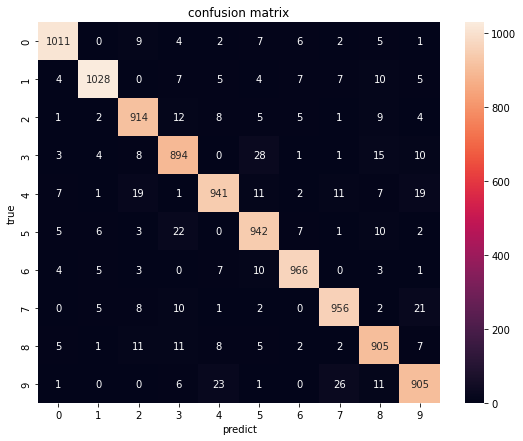

In [ ]:
y_pred = np.array(predictions_test_h3.max(axis=1).indices)
y_true = np.array(emnist_targets_test)
c = confusion_matrix(y_pred, y_true)
print('precision_score:', precision_score(y_true, y_pred, average='macro'))
print('recall_score:', recall_score(y_true, y_pred, average='macro'))
print('f1_score', f1_score(y_true, y_pred, average='macro'))
print('\n')

f,ax=plt.subplots(figsize=(9, 7))
sns.heatmap(c,annot=True,fmt="d",ax=ax) 
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

Because the data is almost balanced, so accuracy, recall, precision and F1 score are very similar, and we can just use accuracy to estimate the model. According to the confusion matrix, we can learn that the prediction of number 1 has the highest accuracy, because the ture prediction was 1028, while other true prediction were lower than it. And the model made the lowest accuracy for number 3, which only has 894 true predictions. 

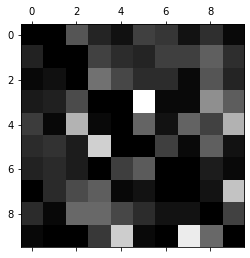

In [ ]:
e = c
row_sums = np.sum(e, axis=1)
err_matrix = e / row_sums
np.fill_diagonal(err_matrix, 0)
plt.matshow(err_matrix, cmap=plt.cm.gray)
plt.show()

I made another plot to to identify what mistakes models are most prone to make, and the more whiter, the more errors. As shown in the figure, the grid in the fourth row and sixth column is the whitest(28 errors), which means the model easily predict 3 as 5, and that's where mistakes are most likely to occur. In addition, the model also easily predict 4 as 2 and 9, 9 as 4 and 7.